In [1]:

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import re
from re import split

In [2]:
def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

mlen = 3 # number states
tlen = 3 # # ways to count time
excludedvids=[]
plas_old = [1/0.48, 1/0.43]
glas_old = [1/4, 1/3]

In [3]:
def parser_arr(filename): # the data is stored in a text file
    # returns arrays of all transitions, transition times, and list of all class and transition thresholds
    transitions = []
    thresholds = []
    vidarrs = []
    timestotrans = []
    statelists = []
    with open(filename) as textfile:
        line = textfile.readline()
        #print('opened', line)
        while line:
            if 'Processing' in line:
                vidnum = line.split('pp_')[-1]
                vidnum = vidnum.split('.avi')[0]
                vidnum = vidnum.split('_')[0]
                #print(vidnum)
                vidnum = int(vidnum)
                line = textfile.readline()
            if 'T threshold'in line:
                thresh_set = []
                for word in line.split():
                    try:
                        thresh_set.append(float(word)) #collect T_treshold
                    except ValueError:
                        pass
                    
                line = textfile.readline()
                #print('after t', line)
                if 'C threshold' in line:
                    for word in line.split():
                        try:
                            thresh_set.append(float(word)) # colect C_threshold
                        except ValueError:
                            pass
                                          
                    #Initialise collecction arrays for this threshold pair
                    if len(thresholds) ==0 or thresholds[-1] != thresh_set:
                        #print(thresh_set)
                        thresholds.append(thresh_set)
                        #vidnums=[]
                        vidarrs.append([[] for i in range(3)])
                        vidsarr = np.zeros((mlen,mlen))
                        transitions.append(vidsarr)
                        #timestotrans.append(np.zeros((tlen,mlen,mlen)))
                        statelists.append([])
                    else:
                        pass    
                    
                    # Collect transition data
                    line = textfile.readline()
                    #print('array lives here', line)
                    trarr = read_square_arr(line, textfile)
                    transitions[-1] += trarr
                    vidarrs[-1][0].append(trarr)
                    vidarrs[-1][1].append(vidnum)
        
                    # Collect time data
                    #print(len(timestotrans[-1]))
                    tiarrs = []
                    for i in range(tlen):
                        line = textfile.readline()
                        #print('array lives there', line)
                        tiarr = read_square_arr_list(line, textfile) 
                        #print(arr)
                        #times += tiarr   
                        #print(times)
                        tiarrs.append(tiarr)
                        line = textfile.readline()
                        print('arr','\n', tiarr)
                    #print("collected 3 rrays: ", tiarrs)
                    vidarrs[-1][2].append(tiarrs)                       
                    # Collect state data 
                    statelists[-1].append([float(f) for f in filter(int_from_text, split(' |\[|]', line))])
                    #print(thresholds[-1])
                    #print(thresholds[-1])
                else:
                    print("missing C thresh")
                
                
                    
            line = textfile.readline()
            #print(line, 'moved on')
                    
                
            
    textfile.close()
    #print(transitions, thresholds)
    return([np.array(transitions), np.array(thresholds), np.array(vidarrs), np.array(timestotrans), statelists]) 

# Decide if text can be converted to floats
def int_from_text(text):
    try:
        float(text)
        return True
    except:
        return False
    
# Generate an integer given a simple text string
def int_from_text_list(textlist):
    #print('textlist: ', textlist)
    elements = []
    for el in textlist:
        nums = [int(s) for s in  re.findall(r'\d+',el)]
        elements.append(nums)
        #print("nums for element ",el,": ", nums )
    #print('elements total: ', elements)
    return elements

# For each of the many nested arrays in this document,
# read just this one
def read_square_arr(line, textfile):
    if '[[' in line:
        arr = np.zeros((mlen,mlen))
        #print(split(' |\[|]', line))
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        #print(linenums)
        arr[0,:] = linenums

        line = textfile.readline()
        #print('array lives here', line)           
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        #print(linenums)
        arr[1,:] = linenums
        
        
        line = textfile.readline()
        #print('array lives here', line)           
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        #print(linenums)
        arr[2,:] = linenums

        return(arr)
        #print(arr,'\n', transitions[-1])
    else:
        print("missing trans array") # just a warning, in case things go south, like due to a misplaced blank line
        
        
sttr = '\[*list' # the correct separator for the text as it's formatted currently
def read_square_arr_list(line, textfile):
    #print('square array start: ', line)
    if '[[' in line:  # marks the start of an array
        arr =[]
        
        while ')]' not in line: # means the row has not yet terminated so continue to the next line 
            line2 = textfile.readline()
            line += line2
            #print('LINE', line)           
            
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)] #Take out newlines, split at separator, keep only non-whitespace
        #print(prelims)
        linenums = int_from_text_list(prelims)
        #print(linenums)
        arr.append(linenums)

        line = textfile.readline()  # second line of array (there are only 2 for the two states in this case)      
        while ')]' not in line:
            line2 = textfile.readline()
            line += line2
            #print('LINE', line)   
            
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)]
        #print(prelims)
        linenums = int_from_text_list(prelims)
        #print(linenums)
        arr.append(linenums)
        
        line = textfile.readline()  # third line of array (there are only 2 for the two states in this case)      
        while ')]' not in line:
            line2 = textfile.readline()
            line += line2
            #print('LINE', line)   
            
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)]
        #print(prelims)
        linenums = int_from_text_list(prelims)
        #print(linenums)
        arr.append(linenums)

        return(np.array(arr))
        #print(arr,'\n')
    else:
        print("missing times array")


        
def ratio(row):
    sums = np.sum(row)
    if sums > 0:
        return row/sums
    else:
        return row
    
def col_norm(array):
    cols = array.T
    cols = np.array([ratio(j)*100 for j in cols])
    return cols.T
def row_norm(array):
    rows = np.array([ratio(i)*100 for i in array])
    return rows

In [4]:

cols = [ 'mediumslateblue','fuchsia','darkviolet' ] #p, g, b
labels = ["Ethylene only touches", "Styrene only touches", "Both touch"]

In [5]:
trans_runs= parser_arr(glob('./wash*both.txt')[0]) # the output file with washed styrene information
print([len(i) for i in trans_runs]) # should be the same length = the number of runs
test = trans_runs[1][0]
print(test[0]) # every video array for the first run 


arr 
 [[list([1023, 773, 626, 1079, 915, 372, 374, 443, 819, 161, 231, 445, 460, 1590, 715, 441, 2694, 1009, 259, 391, 900, 289, 554, 819, 255, 448, 821, 547, 461, 81, 272, 482, 2782])
  list([])
  list([643, 1919, 2332, 1576, 486, 362, 253, 231, 963, 4269, 529, 363, 1355])]
 [list([]) list([]) list([])]
 [list([1405, 125, 2204, 1496, 2153, 49, 506, 298, 417, 973, 1219, 2434, 821, 352])
  list([])
  list([344, 303, 446, 171, 367, 1907, 627, 237, 345, 479, 181, 224, 1430, 755])]]
arr 
 [[list([131, 290, 483, 623, 194, 177, 142, 76, 304, 13, 8, 54, 78, 205, 175, 153, 92, 644, 3, 189, 405, 0, 242, 455, 86, 281, 708, 244, 21, 0, 78, 315, 123])
  list([])
  list([22, 310, 19, 1094, 366, 142, 17, 119, 777, 1136, 91, 40, 358])]
 [list([]) list([]) list([])]
 [list([1, 2, 4, 27, 5, 3, 289, 62, 15, 3, 0, 158, 12, 104]) list([])
  list([221, 18, 61, 0, 5, 1, 6, 23, 1, 9, 4, 14, 37, 170])]]
arr 
 [[list([892, 483, 143, 456, 721, 195, 232, 367, 515, 148, 223, 391, 382, 1385, 540, 288, 2602, 365, 2


len indices 4
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
[[33.  0. 13.]
 [ 0.  0.  0.]
 [14.  0. 14.]] counts [60.86956522  0.         39.13043478]
[[ 4.  0.  9.]
 [ 1.  5.  3.]
 [ 9.  4. 26.]] counts [21.65242165 21.93732194 56.41025641]
[[10.  1.  6.]
 [ 0.  0.  1.]
 [ 6.  0.  6.]] counts [36.2745098   1.96078431 61.76470588]
[[ 0.  0.  3.]
 [ 0.  0.  0.]
 [ 3.  0. 11.]] counts [10.71428571  0.         89.28571429]
[[ 0.  0.  4.]
 [ 0.  9.  2.]
 [ 4.  2. 20.]] counts [ 5.12820513 29.83682984 65.03496503]
[[ 4.  0.  9.]
 [ 0. 14.  3.]
 [ 9.  4. 43.]] counts [15.61355311 29.83193277 54.55451411]
[[ 0.  1.  8.]
 [ 0. 24.  6.]
 [10.  4. 50.]] counts [ 5.20833333 32.4537037  62.33796296]
[[ 1.  0.  7.]
 [ 0.  0.  2.]
 [ 7.  2. 17.]] counts [13.14102564  2.56410256 84.29487179]
[[1. 0. 1.]
 [0. 0. 1.]
 [0. 1. 4.]] counts [16.66666667  6.66666667 76.6666666

Text(0.5, 0.98, 'Transition probabilities for each video')

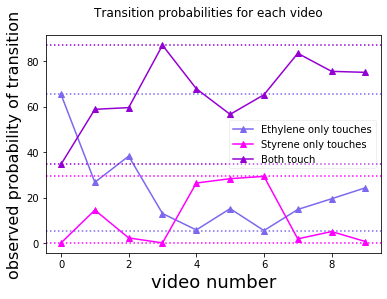

In [6]:
index = list(range(len(trans_runs[0]))) # for all the videos in trans_runs

criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
vidnumset = []
print('\nlen indices', len(index))
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    if True:#len(trans_runs[2][i][0]) == len(vidarrs):
        vidarrs = np.array(trans_runs[2][i][0])
        vidnums = trans_runs[2][i][1]
        print('vidnums', vidnums)
        allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
        print('disallowed numbers', excludedvids)
        print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
        print('allowed indices', allowed_inds)
        vidnums = [vidnums[x] for x in allowed_inds] # Exclude bad videos
        print('vidnums filtered', vidnums)
        vidarrs = vidarrs[allowed_inds]   # Gt the correct statistics for allowed ones
        vidindices = list(range(len(vidarrs)))
        for vidind in vidindices: 
            T_obb = vidarrs[vidind]
            trans_matrices.append(T_obb)
            T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
            #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
            counts =  ratio(np.sum(T_obb_norm, axis=0))*100 # observed transition (to) percentages
            print(T_obb, 'counts', counts)
            #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
                  #np.sum(T_obb, axis=0))
            x1.append(counts[0])
            x2.append(counts[1])
            x3.append(counts[2])
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2, x3])
        print('Total transitions: ',np.sum(vidarrs), np.sum(vidarrs, axis=0), '\n')
#print(t_threshes,c_threshes)    

# Print probabilitie sby video
#stored_y_values = [stored_y_values[x] for x in range(len(stored_y_values))]
stored_y_values = [z for z in stored_y_values if len(z[0]) == len(stored_y_values[0][0])] #np.array(stored_y_values)
print('\nstored_y_values',stored_y_values,'\n', len(stored_y_values), len(stored_y_values[0]), len(stored_y_values[0][1]),stored_y_values[0][1])
y_values_selected = np.array(np.sum(stored_y_values, axis=0))
y_values_selected = col_norm(y_values_selected)
print('\n','\nsummed y values\n', y_values_selected, '\n', len(y_values_selected), len(y_values_selected[0]))
y1,y2,y3 = y_values_selected 
print('\nvidnums',vidnums,y1,y2,y3)
vidnums = list(range(len(y1)))
fig,ax = plt.subplots()
print('\n',len(vidnums), len(y1))   
lines = [y1,y2,y3]
for i in range(len(lines)):
    ax.plot(vidnums, lines[i], c = cols[i], ls = '-', label = labels[i], marker = "^")
    plt.axhline(y = max(lines[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(lines[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'center right', framealpha = 0.3)
plt.xlabel('video number', fontsize=18)
plt.ylabel('observed probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for each video")
    
    
#Print probabilities by v threshold
    
    
    
# Printprobabiliti

vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3]
vidnums filtered [0, 1, 2, 3]
[22.0, 35.0] [21.643211861685057, 29.797229569429295] [12.562096552950216, 5.399703471132042] [65.79469158536473, 64.80306695943867]
2 2


Text(0.5, 0.98, 'Transition probabilities for each value of the stability threshold')

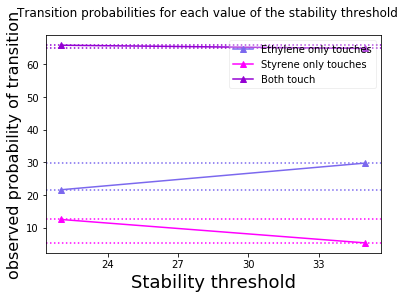

In [7]:
index = list(range(len(trans_runs[0])))

criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    vidarrs = np.array(trans_runs[2][i][0])
    vidnums = trans_runs[2][i][1]
    print('vidnums', vidnums)
    allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
    print('disallowed numbers', excludedvids)
    print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
    print('allowed indices', allowed_inds)
    vidnums = [vidnums[x] for x in allowed_inds]
    print('vidnums filtered', vidnums)
    vidarrs = vidarrs[allowed_inds]   
    vidindices = list(range(len(vidarrs)))
    for vidind in vidindices: 
        T_obb = vidarrs[vidind]
        trans_matrices.append(T_obb)
        T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
        #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
        eigvals, eigvecs = np.linalg.eig(T_obb_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if eigvals[x]==max(eigvals)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        counts =  ratio(np.sum(T_obb_norm, axis=0))*100#/np.sum(T_obb_norm)
        #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
              #np.sum(T_obb, axis=0))
        x1.append(counts[0])
        x2.append(counts[1])
        x3.append(counts[2])
    if len(x1) == len(vidnums):
        #vidarrs = np.cumsum(vidarrs, axis=0)
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2,x3])
#print(t_threshes,c_threshes)    

# Print probabilitie sby c threshold
stored_y_values = np.array(stored_y_values)
cs = list(set(c_threshes))
list.sort(cs)
#print('\n', stored_y_values, '\n', c_threshes, '\n', cs, '\n')
y1 = []
y2 = []
y3 = []
for j in cs:
    inds = np.where(np.array(c_threshes) == j)
    y_values_selected = stored_y_values[inds] # matrix where each row is a t,c that includes the particular c threshold as the c
    #print('\noriginal y values\n', y_values_selected)
    y_values_selected = np.sum(y_values_selected, axis=0)
    #print('\nsummed y values\n',j, y_values_selected)    
    collected_value_across_all_vids = ratio([sum(i) for i in y_values_selected])*100
    #y1,y2,y3 = y_values_selected # one y value per video, and all only for this c threshold, summed over the t thresholds used
    #print(collected_value_across_all_vids, sum(collected_value_across_all_vids))
    y1.append(collected_value_across_all_vids[0])
    y2.append(collected_value_across_all_vids[1])
    y3.append(collected_value_across_all_vids[2])
print(cs,y1,y2,y3)
fig,ax = plt.subplots()
print(len(cs), len(y1))        
lines = [y1,y2,y3]
for i in range(len(lines)):
    ax.plot(cs, lines[i], c = cols[i], ls = '-', label = labels[i], marker="^")
    plt.axhline(y = max(lines[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(lines[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'upper right', framealpha = 0.3)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.xlabel('Stability threshold', fontsize=18)
plt.ylabel('observed probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for each value of the stability threshold")
    
#Print probabilities by v threshold
    
    
    
# Printprobabilities by video

vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3]
vidnums filtered [0, 1, 2, 3]
[40.0, 60.0] [22.91752427768818, 27.97678326085341] [9.94412103718058, 9.13966849366009] [67.13835468513125, 62.883548245486494]
2 2


Text(0.5, 0.98, 'Transition probabilities for each value of the stability threshold')

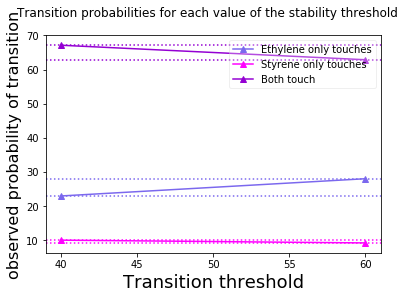

In [8]:
index = list(range(len(trans_runs[0])))

criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    vidarrs = np.array(trans_runs[2][i][0])
    vidnums = trans_runs[2][i][1]
    print('vidnums', vidnums)
    allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
    print('disallowed numbers', excludedvids)
    print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
    print('allowed indices', allowed_inds)
    vidnums = [vidnums[x] for x in allowed_inds]
    print('vidnums filtered', vidnums)
    vidarrs = vidarrs[allowed_inds]   
    vidindices = list(range(len(vidarrs)))
    for vidind in vidindices: 
        T_obb = vidarrs[vidind]
        trans_matrices.append(T_obb)
        T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
        #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
        eigvals, eigvecs = np.linalg.eig(T_obb_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if eigvals[x]==max(eigvals)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        counts =  ratio(np.sum(T_obb_norm, axis=0))*100#/np.sum(T_obb_norm)
        #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
              #np.sum(T_obb, axis=0))
        x1.append(counts[0])
        x2.append(counts[1])
        x3.append(counts[2])
    if len(x1) == len(vidnums):
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2,x3])
#print(t_threshes,c_threshes)    

# Print probabilitie sby t threshold
stored_y_values = np.array(stored_y_values)
ts = list(set(t_threshes))
list.sort(ts)
#print('\n', stored_y_values, '\n', c_threshes, '\n', cs, '\n')
y1 = []
y2 = []
y3 = []
for j in ts:
    inds = np.where(np.array(t_threshes) == j)
    y_values_selected = stored_y_values[inds] # matrix where each row is a t,c that includes the particular c threshold as the c
    #print('\noriginal y values\n', y_values_selected)
    y_values_selected = np.sum(y_values_selected, axis=0)
    #print('\nsummed y values\n',j, y_values_selected)    
    collected_value_across_all_vids = ratio([sum(i) for i in y_values_selected])*100
    #y1,y2,y3 = y_values_selected # one y value per video, and all only for this c threshold, summed over the t thresholds used
    #print(collected_value_across_all_vids, sum(collected_value_across_all_vids))
    y1.append(collected_value_across_all_vids[0])
    y2.append(collected_value_across_all_vids[1])
    y3.append(collected_value_across_all_vids[2])
print(ts,y1,y2,y3)
fig,ax = plt.subplots()
print(len(ts), len(y1))        
lines = [y1,y2,y3]
for i in range(len(lines)):
    ax.plot(ts, lines[i], c = cols[i], ls = '-', label = labels[i], marker="^")
    plt.axhline(y = max(lines[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(lines[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'upper right', framealpha = 0.3)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.xlabel('Transition threshold', fontsize=18)
plt.ylabel('observed probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for each value of the stability threshold")
    
    
#Print probabilities by v threshold
    
    
    
# Printprobabilities by video


len indices 4
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
vidnums filtered [0, 1, 2, 3, 4, 5, 6, 7, 8, 8]
vidnums [0, 1, 2, 3]
disallowed numbers []
disallowed indices []
allowed indices [0, 1, 2, 3]
vidnums filtered [0, 1, 2, 3]
criteria ['40,22', '40,35', '60,22', '60,35']

stored_y_values [[[60.86956521739131, 21.65242165242165, 36.274509803921575, 10.714285714285715, 5.128205128205128, 15.613553113553113, 5.208333333333334, 13.141025641025642, 16.666666666666664, 22.154471544715445], [0.0, 21.937321937321936, 1.9607843137254901, 0.0, 29.8368298368

Text(0.5, 0, 'Run')

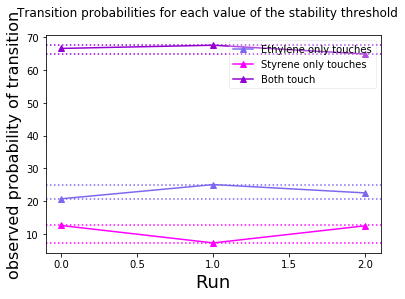

In [9]:
index = list(range(len(trans_runs[0])))
def row_norm(array):
    rows = np.array([ratio(j)*100 for j in array])
    return rows
criteria = []
#t_thresh_list = [20, 33, 46, 60]
stored_y_values = []
c_threshes = []
t_threshes = []
vidnumset = []
print('\nlen indices', len(index))
for i in index:
    x1 = []
    x2 = []
    x3 = []
    trans_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    if True:#len(trans_runs[2][i][0]) == len(vidarrs):
        vidarrs = np.array(trans_runs[2][i][0])
        vidnums = trans_runs[2][i][1]
        print('vidnums', vidnums)
        allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
        print('disallowed numbers', excludedvids)
        print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
        print('allowed indices', allowed_inds)
        vidnums = [vidnums[x] for x in allowed_inds]
        print('vidnums filtered', vidnums)
        vidarrs = vidarrs[allowed_inds]   
        vidindices = list(range(len(vidarrs)))
        for vidind in vidindices: 
            T_obb = vidarrs[vidind]
            trans_matrices.append(T_obb)
            T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))])
            #print(T_obb, '\n', np.around(T_obb_norm, 2), np.sum(T_obb_norm, axis=1))
            eigvals, eigvecs = np.linalg.eig(T_obb_norm.T)
            eig_one_index = [x for x in range(len(eigvals)) if eigvals[x]==max(eigvals)][0]
            eigvec_one = eigvecs[:, eig_one_index]
            evec_one = eigvec_one*100 / np.sum(eigvec_one)
            counts =  ratio(np.sum(T_obb_norm, axis=0))*100#/np.sum(T_obb_norm)
            #print('counts', counts)
            #print('\n y values incoming from e_vector\n',evec_one, np.sum(T_obb_norm, axis=0)*100/np.sum(T_obb_norm), 
                  #np.sum(T_obb, axis=0))
            x1.append(counts[0])
            x2.append(counts[1])
            x3.append(counts[2])
        t_threshes.append(trans_threshes[0])
        c_threshes.append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))
        stored_y_values.append([x1,x2,x3])#,x3])
#print(t_threshes,c_threshes)    
print('criteria', criteria)
# Print probabilitie sby video
#stored_y_values = [stored_y_values[x] for x in range(len(stored_y_values))]
stored_y_values = [z for z in stored_y_values if len(z[0]) == len(stored_y_values[0][0])] #np.array(stored_y_values)
print('\nstored_y_values',stored_y_values,'\n', len(stored_y_values), len(stored_y_values[0]), len(stored_y_values[0][1]),stored_y_values[0][1])
y_values_selected = np.array(np.sum(stored_y_values, axis=2))
print(y_values_selected)
y_values_selected = row_norm(y_values_selected)
print('\n','\nsummed y values\n', y_values_selected, y_values_selected.T,'\n', len(y_values_selected), len(y_values_selected[0]))
y1,y2,y3 = y_values_selected.T 

fig,ax = plt.subplots()  
ts = list(range(len(y1)))
print(len(ts), len(y1))        
lines = [y1,y2,y3]
for i in range(len(lines)):
    ax.plot(ts, lines[i], c = cols[i], ls = '-', label = labels[i], marker="^")
    plt.axhline(y = max(lines[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(lines[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'upper right', framealpha = 0.3)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('observed probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for each value of the stability threshold")
plt.xlabel('Run', fontsize=18)


In [10]:
v1 = y1
v2 = y2
v3=y3

5 5


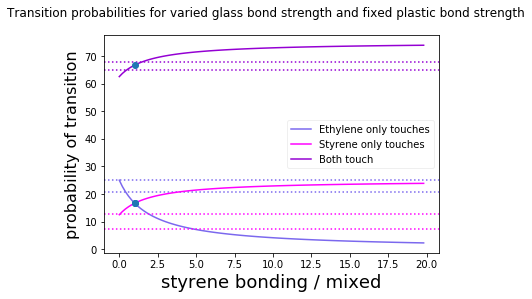

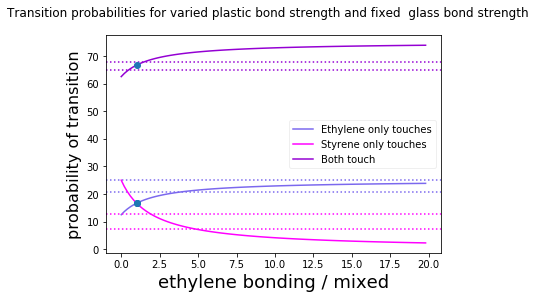

In [11]:
"tESTING HYPOTHESIS WITH all position, early state important, end sate proportional to bond strengths"
#narrow observations array
alphas = np.linspace(0, 20, 100,endpoint =False)
betas = np.linspace(0, 20, 100,endpoint =False)
x1 = []
x2 = []
x3 = []
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    if i ==1:
        alpha1 = aln
    for bln in range(len(betas)):
    #print('\nalpha = %s' %i)
        j = betas[bln]
        if j == 1:
            beta1 = bln
        
        T_expected_narrow = np.asarray([[0, 0, 2*(i+1)],
         [0, 0, 2*(j+1)],
                                       [2/(i+1), 2/(1+j), 2]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        a.append(evec_one[0])
        b.append(evec_one[1])
        c.append(evec_one[2])
    x1.append(a)
    x2.append(b)
    x3.append(c)
print(alpha1,beta1)
lines = [x1,x2,x3]
vs = [v1, v2, v3]
fig,ax = plt.subplots()  
for i in range(len(lines)):
    ax.plot(alphas, [x[beta1] for x in lines[i]], c = cols[i], ls = '-', label = labels[i]) # plot all the points where beta is 1 (and alpha i sanything)
    plt.axhline(y = max(vs[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(vs[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'center right', framealpha = 0.3)
plt.xlabel('styrene bonding / mixed', fontsize=18)
plt.ylabel('probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for varied glass bond strength and fixed plastic bond strength")
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')
fig,ax = plt.subplots()  
for i in range(len(lines)):
    ax.plot(betas, lines[i][alpha1], c = cols[i], ls = '-', label = labels[i]) # plot all the points where beta is 1 (and alpha i sanything)
    plt.axhline(y = max(vs[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(vs[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'center right', framealpha = 0.3)
plt.xlabel('ethylene bonding / mixed', fontsize=18)
plt.ylabel('probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for varied plastic bond strength and fixed  glass bond strength", fontsize=12)
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


5 5


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\

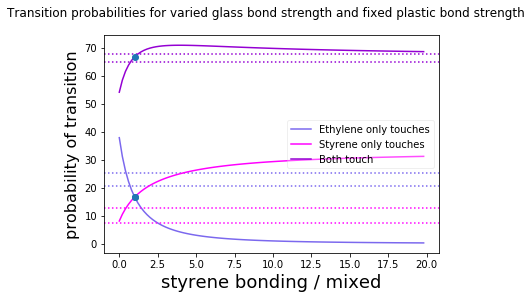

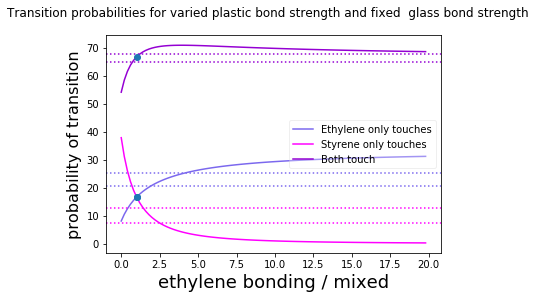

In [12]:
"tESTING HYPOTHESIS WITH all position, ba"
#narrow observations array
alphas = np.linspace(0, 20, 100,endpoint =False)
betas = np.linspace(0, 20, 100,endpoint =False)
x1 = []
x2 = []
x3 = []
for aln in range(len(alphas)):
    a = []
    b = []
    c = []
    i = alphas[aln]
    if i ==1:
        alpha1 = aln
    for bln in range(len(betas)):
    #print('\nalpha = %s' %i)
        j = betas[bln]
        if j == 1:
            beta1 = bln
        
        p = (j*2/(18*(1+i+j)*(3+i))+
             4*2*(j+1)/(18*2*(3+i)*(1+i+j)*(2+i+j)))
        g = (i*2/(18*(1+i+j)*(3+j))+
             4*2*(i+1)/(18*2*(3+j)*(1+i+j)*(2+i+j)))
        m = (2*j*(i+1)/(18*(3+i)*(1+j+i))+
              8*(i+1)*(j+1)/(18*2*(3+j)*(i+j+1)*(i+j+2))+
              8*(j+1)*(i+1)/(18*2*(3+i)*(i+j+1)*(i+j+2))+
              i*2*(1+j)/(18*(3+j)*(1+i+j)))

        T_expected_narrow = np.asarray([[p, g, m],
                                        [p, g, m],
         [p, g, m]])
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        a.append(evec_one[0])
        b.append(evec_one[1])
        c.append(evec_one[2])
    x1.append(a)
    x2.append(b)
    x3.append(c)
print(alpha1,beta1) 
lines = [x1,x2,x3]
vs = [v1, v2, v3]
fig,ax = plt.subplots()  
for i in range(len(lines)):
    ax.plot(alphas, [x[beta1] for x in lines[i]], c = cols[i], ls = '-', label = labels[i]) # plot all the points where beta is 1 (and alpha i sanything)
    plt.axhline(y = max(vs[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(vs[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'center right', framealpha = 0.3)
plt.xlabel('styrene bonding / mixed', fontsize=18)
plt.ylabel('probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for varied glass bond strength and fixed plastic bond strength")
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')
fig,ax = plt.subplots()  
for i in range(len(lines)):
    ax.plot(betas, lines[i][alpha1], c = cols[i], ls = '-', label = labels[i]) # plot all the points where beta is 1 (and alpha i sanything)
    plt.axhline(y = max(vs[i]), c = cols[i], ls = ':') # maximum observed transition probability across all runs
    plt.axhline(y = min(vs[i]), c = cols[i], ls = ':') # minimum observed probability to transition to state
ax.legend(loc = 'center right', framealpha = 0.3)
plt.xlabel('ethylene bonding / mixed', fontsize=18)
plt.ylabel('probability of transition', fontsize=16)
fig.suptitle("Transition probabilities for varied plastic bond strength and fixed  glass bond strength", fontsize=12)
plt.plot((1, 1,1),(100/6,100/6,400/6), 'o')

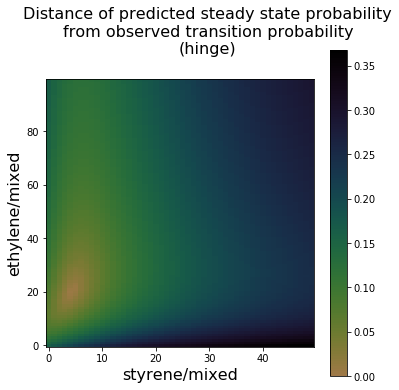

In [13]:
from matplotlib.colors import DivergingNorm

def mean(li):
    return(sum(li) / len(li))
def rang(li):
    return(abs(max(li)-min(li)))

alphas,betas = np.meshgrid(np.linspace(0,5, 50,endpoint =False),np.linspace(0,10, 100,endpoint =False))
x1 = []
x2 = []
x3 = []
tolerances = [ mean(v1),mean(v2),mean(v3)]
tols = [ rang(v1),rang(v2),rang(v3)]
def distance_from_data(alph,bet):
    T_expected_narrow = np.asarray([[0, 0, 2*(alph+1)],
     [0, 0, 2*(bet+1)],
                                   [2/(alph+1), 2/(1+bet), 2]])
    T_expected_broad = T_expected_narrow
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
        
    return(vector_dist(tolerances, evec_one) / vector_dist(tolerances, [0]*len(tolerances))) #distance between data and model, normalized to the size of the data's value
dfd = np.vectorize(distance_from_data)
dists = dfd(alphas, betas)
fig,ax = plt.subplots(figsize=(6,6))
plt.imshow(dists, cmap="cubehelix_r", norm=DivergingNorm(0)); plt.colorbar()

ax.set_aspect(1./ax.get_data_ratio())
plt.xlabel('styrene/mixed', fontsize=16)
plt.ylabel('ethylene/mixed', fontsize=16)
fig.suptitle("Distance of predicted steady state probability\nfrom observed transition probability\n(hinge)",fontsize=16)
plt.gca().invert_yaxis()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


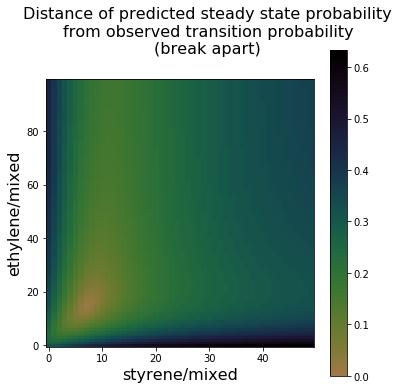

In [14]:

from matplotlib.colors import DivergingNorm

def mean(li):
    return(sum(li) / len(li))
def rang(li):
    return(abs(max(li)-min(li)))

alphas,betas = np.meshgrid(np.linspace(0,5, 50,endpoint =False),np.linspace(0,10, 100,endpoint =False))
x1 = []
x2 = []
x3 = []
tolerances = [ mean(v1),mean(v2),mean(v3)]
tols = [ rang(v1),rang(v2),rang(v3)]
def distance_from_data(alph,bet):
    i = alph
    j = bet
    p = (j*2/(18*(1+i+j)*(3+i))+
         4*2*(j+1)/(18*2*(3+i)*(1+i+j)*(2+i+j)))
    g = (i*2/(18*(1+i+j)*(3+j))+
         4*2*(i+1)/(18*2*(3+j)*(1+i+j)*(2+i+j)))
    m = (2*j*(i+1)/(18*(3+i)*(1+j+i))+
          8*(i+1)*(j+1)/(18*2*(3+j)*(i+j+1)*(i+j+2))+
          8*(j+1)*(i+1)/(18*2*(3+i)*(i+j+1)*(i+j+2))+
          i*2*(1+j)/(18*(3+j)*(1+i+j)))

    T_expected_narrow = np.asarray([[p, g, m],
                                    [p, g, m],
     [p, g, m]])
    T_expected_broad = T_expected_narrow
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
        
    return(vector_dist(tolerances, evec_one) / vector_dist(tolerances, [0]*len(tolerances))) #distance between data and model, normalized to the size of the data's value
dfd = np.vectorize(distance_from_data)
dists = dfd(alphas, betas)
fig,ax = plt.subplots(figsize=(6,6))
plt.imshow(dists, cmap="cubehelix_r", norm=DivergingNorm(0)); plt.colorbar()

ax.set_aspect(1./ax.get_data_ratio())
plt.xlabel('styrene/mixed', fontsize=16)
plt.ylabel('ethylene/mixed', fontsize=16)
fig.suptitle("Distance of predicted steady state probability\nfrom observed transition probability\n(break apart)",fontsize=16)
plt.gca().invert_yaxis()


In [15]:
parser_arr(glob('./wash*both.txt')[0])

arr 
 [[list([1023, 773, 626, 1079, 915, 372, 374, 443, 819, 161, 231, 445, 460, 1590, 715, 441, 2694, 1009, 259, 391, 900, 289, 554, 819, 255, 448, 821, 547, 461, 81, 272, 482, 2782])
  list([])
  list([643, 1919, 2332, 1576, 486, 362, 253, 231, 963, 4269, 529, 363, 1355])]
 [list([]) list([]) list([])]
 [list([1405, 125, 2204, 1496, 2153, 49, 506, 298, 417, 973, 1219, 2434, 821, 352])
  list([])
  list([344, 303, 446, 171, 367, 1907, 627, 237, 345, 479, 181, 224, 1430, 755])]]
arr 
 [[list([131, 290, 483, 623, 194, 177, 142, 76, 304, 13, 8, 54, 78, 205, 175, 153, 92, 644, 3, 189, 405, 0, 242, 455, 86, 281, 708, 244, 21, 0, 78, 315, 123])
  list([])
  list([22, 310, 19, 1094, 366, 142, 17, 119, 777, 1136, 91, 40, 358])]
 [list([]) list([]) list([])]
 [list([1, 2, 4, 27, 5, 3, 289, 62, 15, 3, 0, 158, 12, 104]) list([])
  list([221, 18, 61, 0, 5, 1, 6, 23, 1, 9, 4, 14, 37, 170])]]
arr 
 [[list([892, 483, 143, 456, 721, 195, 232, 367, 515, 148, 223, 391, 382, 1385, 540, 288, 2602, 365, 2

[array([[[ 59.,   2.,  78.],
         [  1.,  52.,  19.],
         [ 79.,  18., 214.]],
 
        [[ 58.,   1.,  52.],
         [  0.,  16.,   9.],
         [ 53.,   8., 198.]],
 
        [[ 44.,   2.,  78.],
         [  1.,  38.,  19.],
         [ 79.,  18., 140.]],
 
        [[ 38.,   1.,  20.],
         [  0.,   0.,   1.],
         [ 22.,   0.,  26.]]]),
 array([[40., 22.],
        [40., 35.],
        [60., 22.],
        [60., 35.]]),
 array([[list([array([[33.,  0., 13.],
        [ 0.,  0.,  0.],
        [14.,  0., 14.]]), array([[ 4.,  0.,  9.],
        [ 1.,  5.,  3.],
        [ 9.,  4., 26.]]), array([[10.,  1.,  6.],
        [ 0.,  0.,  1.],
        [ 6.,  0.,  6.]]), array([[ 0.,  0.,  3.],
        [ 0.,  0.,  0.],
        [ 3.,  0., 11.]]), array([[ 0.,  0.,  4.],
        [ 0.,  9.,  2.],
        [ 4.,  2., 20.]]), array([[ 4.,  0.,  9.],
        [ 0., 14.,  3.],
        [ 9.,  4., 43.]]), array([[ 0.,  1.,  8.],
        [ 0., 24.,  6.],
        [10.,  4., 50.]]), array([[ 1.

In [16]:
# GEt regime of transitions
#parser_arr(glob('./timestotrans.txt')[0])
def flattener(array_of_lists):
    return(np.array([x for y in array_of_lists for x in y]))

trans_runs= parser_arr(glob('./wash*both.txt')[0])
reduced_times = dict()
t_threshes = []
c_threshes = []    
index = list(range(len(trans_runs[0])))

vidnumset = []
print('\nlen indices', len(index))
for i in index:
    #xs_tr = []
    #xs_ti = []
    trans_matrices = []
    times_matrices = []
    N_transitions = trans_runs[0][i]
    trans_threshes = trans_runs[1][i]
    #print(np.shape(trans_runs[2]))
    transarrs = np.array(trans_runs[2][i][0])
    timarrs = np.array(trans_runs[2][i][2]) ##########
    vidnums = trans_runs[2][i][1]
    print('vidnums', vidnums)
    allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
    print('disallowed numbers', excludedvids)
    print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
    print('allowed indices', allowed_inds)
    vidnums = [vidnums[x] for x in allowed_inds]
    print('vidnums filtered', vidnums)
    transarrs = transarrs[inds]
    timarrs = timarrs[inds]
    #print(row_norm(vidarrs))
    #vidarrs = np.cumsum(vidarrs, axis=0)
    vidindices = list(range(len(transarrs)))
    #print(vidnums)
    for vidindex in vidindices: 
        Tr_obb = transarrs[vidindex]
        trans_matrices.append(Tr_obb)
        #print('Transitions ob', Tr_obb)
        Ti_obb = timarrs[vidindex] ##################
        times_matrices.append(Ti_obb)
        #print('Times ob', Ti_obb)
    #print("\nTransitions", trans_matrices)
    #print("\n\nTimes", times_matrices)
    t_threshes.append(trans_threshes[0])
    c_threshes.append(trans_threshes[1])
    

    
    #print(len(times_matrices), len(times_matrices[0]))
    #print(np.shape(times_matrices[0][0]))
    timestotrans = np.array(times_matrices)
    print('tt_shape', np.shape(timestotrans))
    #print(type(timestotrans))
    timestotrans = np.moveaxis(timestotrans, [0,1,2,3], [3, 0,1,2])
    print('tt_shape', np.shape(timestotrans))
    #print(timestotrans[0], '\n\n',type(timestotrans[0][0][0]), timestotrans[0][0][0], [x for y in timestotrans[0][0][0] for x in y])
    indices = np.shape(timestotrans)
    #print(len(indices))
    reduced_timestotrans = np.empty(indices[0:-2], dtype = object)
    #print(reduced_timestotrans)
    for m in range(indices[0]):
        time = timestotrans[m]
        for j in range(indices[1]):
            fromrow = time[j]
            collector = []
            for k in range(indices[2]):
                tocolumn = fromrow[k]
                #print("TOCOLUMN", tocolumn)
                tocolumn = np.array(flattener(tocolumn))
                #print("flattened", tocolumn)
                
                collector.extend(tocolumn)
            if collector ==[]: #if there's nothing in a ROW
                reduced_timestotrans[m,j]= collector# [np.nan] # set the from row
            else:
                reduced_timestotrans[m,j] = collector
            #print('timesrow',reduced_timestotrans[m,j] )
    #timestotrans = np.concatenate(timestotrans, axis=-1)
    print('SHAPE', np.shape(reduced_timestotrans))
    print('reduced', reduced_timestotrans[0])
    print('len of rows per time ', [[len(i) for i in x] for x in reduced_timestotrans])
    print(len([x for y in np.ravel(timestotrans) for x in y]), len([i for x in np.ravel(reduced_timestotrans) for i in x]))
    reduced_times[i] = reduced_timestotrans
    #reduced_timestotrans = per time, pper origin, list of transitions times
    

arr 
 [[list([1023, 773, 626, 1079, 915, 372, 374, 443, 819, 161, 231, 445, 460, 1590, 715, 441, 2694, 1009, 259, 391, 900, 289, 554, 819, 255, 448, 821, 547, 461, 81, 272, 482, 2782])
  list([])
  list([643, 1919, 2332, 1576, 486, 362, 253, 231, 963, 4269, 529, 363, 1355])]
 [list([]) list([]) list([])]
 [list([1405, 125, 2204, 1496, 2153, 49, 506, 298, 417, 973, 1219, 2434, 821, 352])
  list([])
  list([344, 303, 446, 171, 367, 1907, 627, 237, 345, 479, 181, 224, 1430, 755])]]
arr 
 [[list([131, 290, 483, 623, 194, 177, 142, 76, 304, 13, 8, 54, 78, 205, 175, 153, 92, 644, 3, 189, 405, 0, 242, 455, 86, 281, 708, 244, 21, 0, 78, 315, 123])
  list([])
  list([22, 310, 19, 1094, 366, 142, 17, 119, 777, 1136, 91, 40, 358])]
 [list([]) list([]) list([])]
 [list([1, 2, 4, 27, 5, 3, 289, 62, 15, 3, 0, 158, 12, 104]) list([])
  list([221, 18, 61, 0, 5, 1, 6, 23, 1, 9, 4, 14, 37, 170])]]
arr 
 [[list([892, 483, 143, 456, 721, 195, 232, 367, 515, 148, 223, 391, 382, 1385, 540, 288, 2602, 365, 2

 [list([5221, 249, 591, 2625, 1112]) list([]) list([357, 1232, 246])]]
arr 
 [[list([10267, 989, 1177, 732]) list([])
  list([1440, 404, 676, 71, 769, 874, 638, 1860])]
 [list([]) list([]) list([])]
 [list([2059, 1003, 667, 1079, 263, 864, 699, 4111, 968]) list([])
  list([684, 1570, 2125, 915, 1192, 296, 907, 1720, 505, 240, 448, 390, 567, 248, 648, 640, 3288, 609])]]
arr 
 [[list([9553, 61, 336, 229]) list([])
  list([31, 94, 173, 2, 190, 2, 282, 1341])]
 [list([]) list([]) list([])]
 [list([1872, 340, 88, 734, 16, 8, 74, 2060, 0]) list([])
  list([4, 44, 1807, 116, 15, 25, 72, 639, 209, 13, 31, 87, 249, 11, 464, 121, 49, 358])]]
arr 
 [[list([714, 928, 841, 503]) list([])
  list([1409, 310, 503, 69, 579, 872, 356, 519])]
 [list([]) list([]) list([])]
 [list([187, 663, 579, 345, 247, 856, 625, 2051, 968]) list([])
  list([680, 1526, 318, 799, 1177, 271, 835, 1081, 296, 227, 417, 303, 318, 237, 184, 519, 3239, 251])]]
arr 
 [[list([1429, 362, 451, 563, 1179, 1052, 3798]) list([2871])


Times: 
means,  [897.0, 589.0, 931.0]
vaars,  [795342.0, 0.0, 1055134.0]
[list([637, 627, 821, 433, 537, 451, 528, 412, 1052, 3839, 2858, 28, 600, 752, 698, 1086, 323, 431, 1562, 271])
 list([589])
 list([323, 634, 634, 686, 69, 1323, 553, 677, 285, 739, 601, 189, 1063, 1009, 688, 1558, 292, 640, 338, 1707, 445, 1957, 359, 526, 1431, 5476])] 

means,  [554.0, 221.0, 675.0]
vaars,  [827860.0, 0.0, 1118995.0]
[list([0, 410, 454, 2, 332, 13, 364, 36, 708, 3718, 2547, 5, 532, 53, 594, 713, 220, 257, 56, 70])
 list([221])
 list([178, 532, 536, 99, 2, 826, 112, 641, 78, 592, 209, 3, 185, 901, 497, 1386, 0, 344, 77, 1501, 294, 1768, 95, 106, 1235, 5355])] 

means,  [343.0, 368.0, 256.0]
vaars,  [102191.0, 0.0, 33633.0]
[list([637, 217, 367, 431, 205, 438, 164, 376, 344, 121, 311, 23, 68, 699, 104, 373, 103, 174, 1506, 201])
 list([368])
 list([145, 102, 98, 587, 67, 497, 441, 36, 207, 147, 392, 186, 878, 108, 191, 172, 292, 296, 261, 206, 151, 189, 264, 420, 196, 121])] 

MAX 5355
BINS [0.0, 

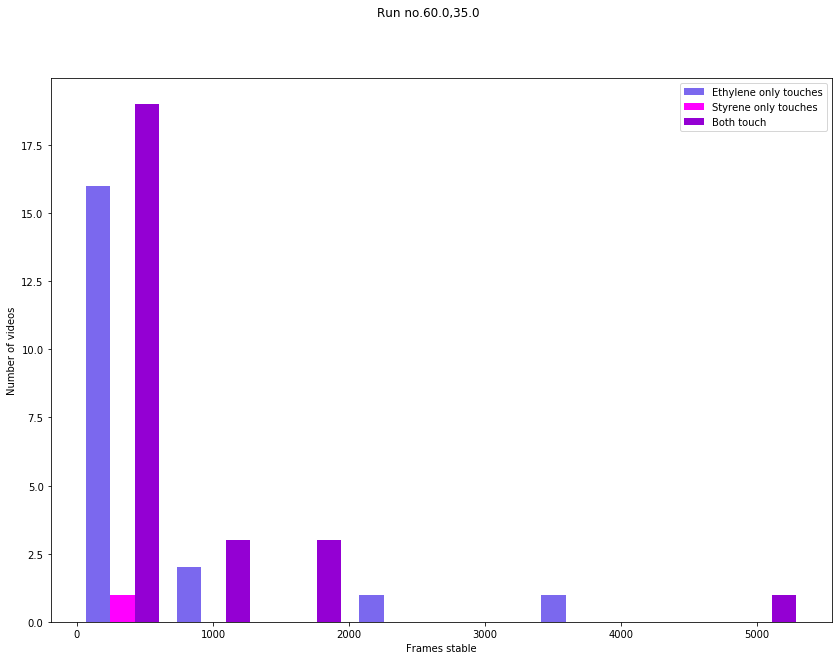

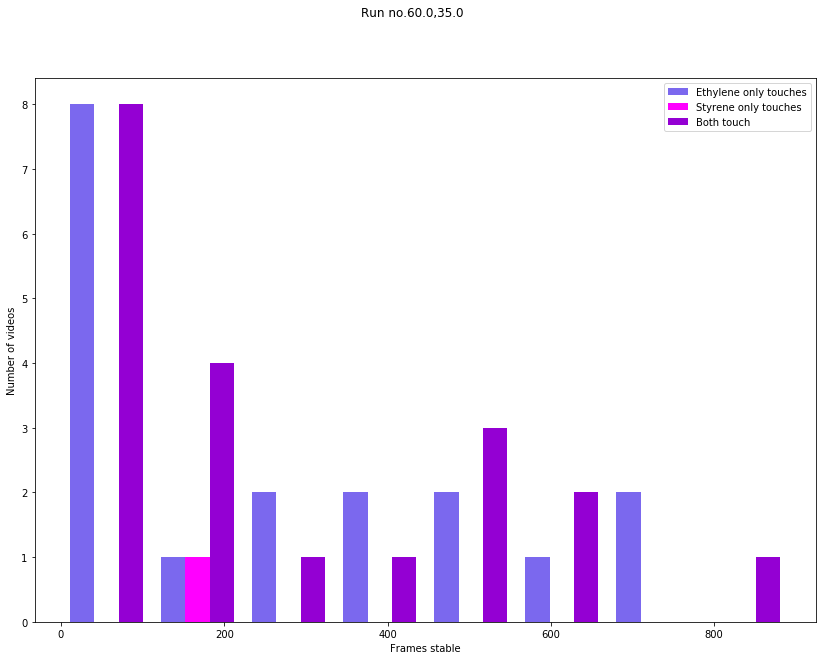

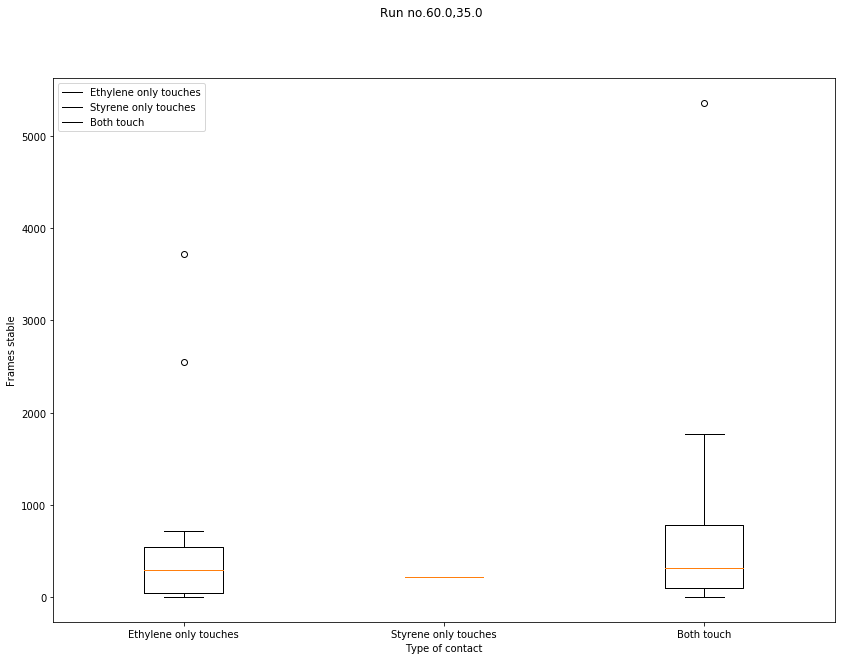

In [17]:

def binnerseq(seq, nbins, discardfrac):
    maximum = np.nanmax([x for y in seq for x in y])
    print('MAX', maximum)
    rang = maximum
    bins = list(np.linspace(0, np.round(maximum/discardfrac), nbins-1))
    #bins.append(maximum) 
    print('BINS', bins)
    return np.array(bins)
    

for i in index[0:1]:    
    total_time = (reduced_times[i])[0]
    stable_time= (reduced_times[i])[1]
    unstable_time= (reduced_times)[i][2]
    #print(stable_time.T)
    # for each time, separate the three axes
    times = [total_time, stable_time, unstable_time]
    print("Times: ")
    for i in times:
        print('means, ',[np.round(np.nanmean(x)) for x in i])        
        print('vaars, ',[np.round(np.nanvar(x)) for x in i])
        print(i, '\n')
    timenames = ["Frames between transitions", "Frames stable", "Frames unstable"]
    time = times[1]
    timename = timenames[1]
    #times, timenames = times[1:2], timenames[1:2]
    
    
    fig, ax = plt.subplots(figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  10, 1))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    fig, ax = plt.subplots(figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  10, 6))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    
    fig, ax = plt.subplots( figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))  
    ax.set_prop_cycle(color=cols)
    ax.boxplot(time, labels = labels)####
    ax.set_ylabel(timename)
    ax.set_xlabel("Type of contact")
    ax.legend(labels)